# Set up environment
This cell loads the libraries we need and sets environmentla variables.

In [27]:
# import libraries
import pandas as pd
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
import seaborn as sns
import os
import scipy.stats as scp


# set plotting theme/style
sns.set(context='talk', style='white')

# assign study-specific variables
TR = 0.8 # in seconds

#project_dir = '/Users/catcamacho/Library/CloudStorage/Box-Box/CCP/HBN_study/Njenga_project/'
project_dir = '/Users/sallynjenga/Library/CloudStorage/Box-Box/Njenga_project/'
out_dir = os.path.join(project_dir, 'DATA', 'processed_data')
raw_dir = os.path.join(project_dir, 'DATA', 'raw_data')
vid_dir = os.path.join(project_dir, 'DATA', 'video_data')
sample_file = os.path.join(project_dir, 'DATA', 'helper_files','sample_gord.32k_fs_LR.pscalar.nii')

# get parcel and network labels
parcel_labels = nib.load(sample_file).header.get_axis(1).name
network_labels = []
for s in parcel_labels:
    b = s.split('_')
    if len(b)<2:
        network_labels.append(b[0])
    else:
        network_labels.append(b[1])
network_labels = np.array(network_labels)
network_names, network_sizes = np.unique(network_labels, return_counts=True)

# define measures of interest
networks_of_interest = ['Auditory', 'CinguloOperc', 'Default', 'DorsalAttn', 'FrontoParietal',
                        'SMhand', 'SMmouth', 'Salience', 'VentralAttn', 'Visual']

vidfeat_of_interest = ['Positive','Negative','SpokenWords','Brightness',
                       'SaliencyFract','Loudness']

# Define functions
These cells store custom functions used in our analyses.

In [8]:
# Compile timeseries data
def compile_ts_data(subdf, movie, datadir, outfile):
    """
    combine timeseries data for each movie together into 1 file
    
    Parameters
    ----------
    subdf: DataFrame
        A dataframe with subject IDs as the index. Includes IDs for all usable data.
    movie: str
        Corresponds with the str for the movie content to concatenate (e.g., "DM" or "TP").
    datadir: folder path
        Path to folder with the subject timeseries ciftis.
    outfile: file path
        Path including filename to save the output data of shape Ntimepoints x Nparcels x Nsubjects.
    
    Returns
    -------
    data: numpy array
        The compiled data of shape Ntimepoints x Nparcels x Nsubjects
    """
    from sklearn.preprocessing import StandardScaler
    if not isinstance(subdf, pd.DataFrame):
        subdf = pd.read_csv(subdf, index_col=0)
    
    for sub in subdf.index:
        file = '{0}{1}_task-movie{2}_bold1_AP_Atlas_rescale_resid0.9_filt_gordonseitzman.32k_fs_LR.ptseries.nii'.format(datadir,sub, movie)
        if sub == subdf.index[0]:
            data = StandardScaler().fit_transform(nib.load(file).get_fdata())
            data = np.expand_dims(data, axis=2)
        else:
            t = StandardScaler().fit_transform(nib.load(file).get_fdata())
            t = np.expand_dims(t, axis=2)
            data = np.concatenate([data,t],axis=2)
    
    print('Compile data from {0} brain regions measured at {1} timepoints from {2} participants.'.format(data.shape[1],data.shape[0],data.shape[2]))
    np.save(outfile, data)
    return(data)


def compute_phase(group_ts_data, outfile):
    """
    compute phase angles for each parcel timeseries
    
    Parameters
    ----------
    group_ts_data: filepath OR numpy array
        File or numpy array with compiled timeseries data of shape Ntimepoints x Nparcels x Nsubjects 
        OR Ntimepoints x Nfeatures
    
    Returns
    -------
    phase_data: numpy array
        The compiled data of shape Ntimepoints x Nparcels x Nsubjects
    """
    from scipy.signal import hilbert
    
    if not isinstance(group_ts_data, np.ndarray):
        group_ts_data = np.load(group_ts_data)
    
    phase_data = np.zeros_like(group_ts_data)
    
    if len(group_ts_data.shape)==3:
        for a in range(0,group_ts_data.shape[1]):
            for b in range(0,group_ts_data.shape[2]):
                phase_data[:,a,b] = np.angle(hilbert(group_ts_data[:,a,b]), deg=False)
    elif len(group_ts_data.shape)==2:
        for a in range(0,group_ts_data.shape[1]):
                phase_data[:,a] = np.angle(hilbert(group_ts_data[:,a]), deg=False)
    
    np.save(outfile, phase_data)
    
    return(phase_data)



def compute_ips(group_phase_data, outprefix, intersub=True, interregion=False, savemean=True):
    """
    parcel-wise instantaneous phase synchrony- output pairwise IPS and mean global IPS
    
    Parameters
    ----------
    group_phase_data: numpy array
        The compiled data of shape Ntimepoints x Nparcels x Nsubjects
    outprefix: string
        The filepath and file prefix for the saved IPS data.
    intersub: bool
        Set to True to compute intersubject phase synchrony.  Set to False for inter-region.
    interregion: bool
        Set to True to computer inter-region instantaneous phase synchrony. Set to False for intersubject. 
    savemean: bool
        Set to True to save average IPS (across subjects)
        
    Returns
    -------
    ips_data: numpy array
        Instantaneous phase synchrony data of shape Nparcels x Nsubjects x Nsubjects x Ntimepoints 
        OR Nsubjects x Nparcels x Nparcels x Ntimepoints
    mean_ips_data: numpy array
        Instantaneous phase synchrony data, averaged across time, of shape Nparcels x Ntimepoints
        
    """
    import itertools
    
    if not isinstance(group_phase_data, np.ndarray):
        group_phase_data = np.load(group_phase_data)
    
        
    if intersub:
        if os.path.isdir(outprefix):
            file_name = os.path.join(outprefix, 'ips_data.dat')
        else:
            file_name = outprefix + 'ips_data.dat'
        ips_data = np.empty(file_name, dtype=np.float32, mode='w+',
                              shape=(group_phase_data.shape[1],
                                     group_phase_data.shape[2],
                                     group_phase_data.shape[2],
                                     group_phase_data.shape[0]))

        subs = range(0, group_phase_data.shape[2])
        for region in range(0, group_phase_data.shape[1]):
            combs = itertools.combinations(subs, 2)
            for c in combs:
                sub1 = group_phase_data[:, region, c[0]]
                sub2 = group_phase_data[:, region, c[1]]
                a = 1 - np.sin(np.abs(sub1 - sub2) / 2)
                ips_data[region,c[0],c[1],:] = a
                ips_data[region,c[1],c[0],:] = a

        if savemean:
            mask = np.tri(ips_data.shape[2], ips_data.shape[2], -1, dtype=int)
            mean_ips_data = np.mean(ips_data[:,mask==1,:], axis=1)
            if os.path.isdir(outprefix):
                mean_file_name = os.path.join(outprefix, 'mean_isps_data.npy')
            else:
                mean_file_name = outprefix + 'mean_isps_data.npy'
            np.save(mean_file_name, mean_ips_data.T)
            return(mean_ips_data, ips_data)
        else:
            return(ips_data)
        
    if interregion:
        if os.path.isdir(outprefix):
            file_name = os.path.join(outprefix, 'ips_data.npy')
        else:
            file_name = outprefix + 'ips_data.npy'
        ips_data = np.empty((group_phase_data.shape[2],
                             group_phase_data.shape[1],
                             group_phase_data.shape[1],
                             group_phase_data.shape[0]))

        regions = range(0, group_phase_data.shape[1])
        for sub in range(0, group_phase_data.shape[2]):
            combs = itertools.combinations(regions, 2)
            for c in combs:
                sub1 = group_phase_data[:, c[0], sub]
                sub2 = group_phase_data[:, c[1], sub]
                a = 1 - np.sin(np.abs(sub1 - sub2) / 2)
                ips_data[sub,c[0],c[1],:] = a
                ips_data[sub,c[1],c[0],:] = a
        np.save(file_name, ips_data)
        
        if savemean:
            mean_ips_data = np.mean(ips_data, axis=0)
            if os.path.isdir(outprefix):
                mean_file_name = os.path.join(outprefix, 'mean_isps_data.npy')
            else:
                mean_file_name = outprefix + 'mean_isps_data.npy'

            np.save(mean_file_name, mean_ips_data.T)
            return(mean_ips_data, ips_data)
        else:
            return(ips_data)

        
        
def brain_bx_crosscorr(brain, bx):
    """
    
    Parameters
    ----------
    brain: numpy array
        neural phase data of shape Nsubjects x Nparcels x Nparcels x Ntimepoints
    bx: numpy array
        Nfeatures x Ntimepoints
    
    Returns
    -------
    cross_corr: numpy array
        
    
    """
    
    cross_corr = np.empty([brain.shape[0], brain.shape[1], brain.shape[2], bx.shape[1]])

    # compute lags
    for sub in range(0, brain.shape[0]):
        for n1 in range(0, brain.shape[1]):
            for n2 in range(0, brain.shape[1]):
                if n1!=n2:
                    for b in range(0, bx.shape[1]):
                        res = correlate(brain[sub, n1, n2, :], bx[:,b], mode='same')
                        lags = correlation_lags(brain[sub, n1, n2, :].shape[0], bx[:,b].shape[0], mode='same')
                        cross_corr[sub, n1, n2, b] = lags[np.argmax(res)]
                        cross_corr[sub, n2, n1, b] = lags[np.argmax(res)]
    
    return(cross_corr)
    

# Analysis
These cells perform the following analysis steps:
1. Compute inter- and intra-network dynamic connectivity
2. Test synchronization with emotion ratings
3. Compute lagged synchronization with emotion ratings

## 1. Compute inter- and intra-network dynamic connectivity

### prepare data

In [9]:
# Read in raw fMRI timeseries data
tseries = np.load(os.path.join(raw_dir, 'compiled_ts_data_movieDM.npy'))

# Convert to phase angles and save data
phasefile = os.path.join(out_dir, 'phase_data_movieDM.npy')
phase = compute_phase(tseries, phasefile)

print(phase.shape)

(750, 394, 620)


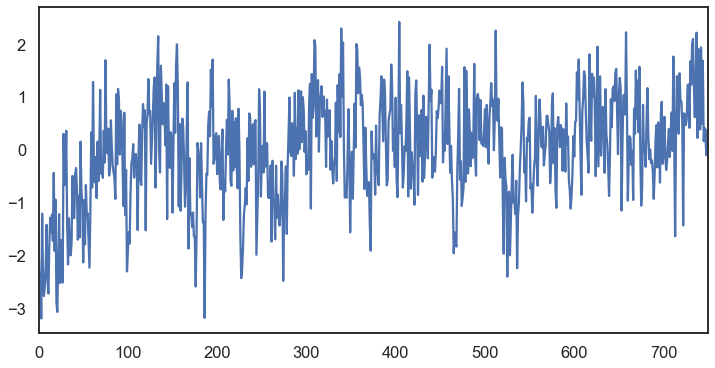

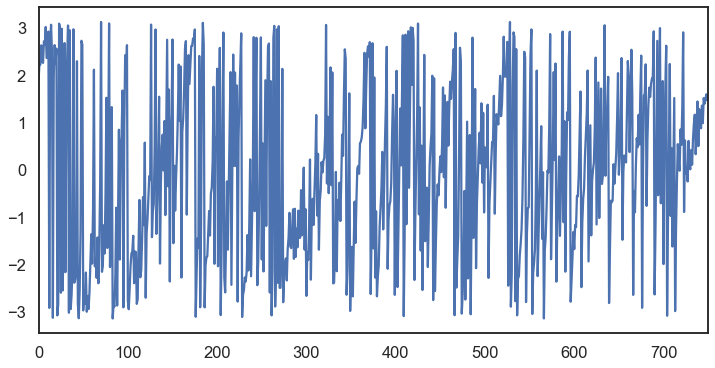

In [12]:
# TODO: graph raw signal and phase signal for single participant/region


plt.figure(figsize=(12, 6))
plt.plot(tseries[:,0, 300])
plt.xlim(0,750)
plt.show()
plt.close()




plt.figure(figsize=(12, 6))
plt.plot(phase[:,0, 300])
plt.xlim(0,750)
plt.show()
plt.close()



### compute intra-network dynamic connectivity

In [23]:
# limit data just to default mode network
net_phase = phase[:, network_labels=='Default', :]

# compute pair-wise network dynamic connectivity
outprefix = os.path.join(out_dir, 'within_network_Default_movieDM_')
mean_ips, ips = compute_ips(net_phase, outprefix, intersub=False, interregion=True, savemean=True)
# save group mean
mask = np.tri(mean_ips.shape[0], mean_ips.shape[0], -1, dtype=int)
mean_default_ips = np.mean(mean_ips[mask==1,:], axis=0)
# save participant-level data
participant_default_ips = np.mean(ips[:,mask==1,:], axis=1)
np.save(os.path.join(out_dir, 'participant_mean_Default_ips_movieDM.npy'), participant_default_ips)






# save data
np.save(os.path.join(out_dir, 'group_mean_Default_ips_movieDM.npy'), mean_default_ips)





In [24]:
print(participant_default_ips.shape)

(620, 750)


In [16]:
x=np.array([[1,2,3],[4,5,6],[7,8,9]])
x



array([[1, 2, 3],
       [4, 5, 6],
       [7, 8, 9]])

In [22]:
print(x[:,2])

[3 6 9]


In [20]:
print(ips.shape)


(620, 41, 41, 750)


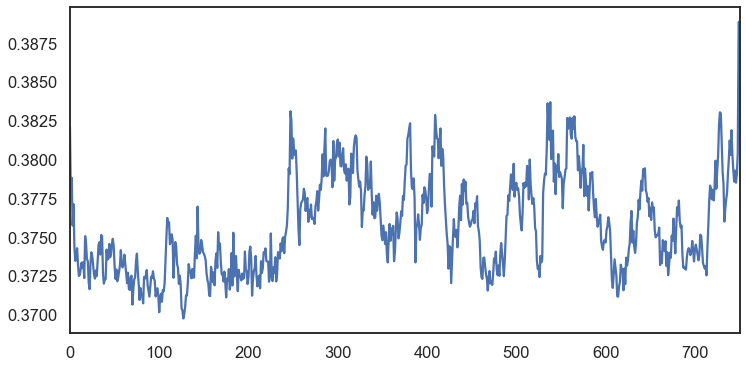

In [17]:
# plot group mean
plt.figure(figsize=(12, 6))
plt.plot(mean_default_ips)
plt.xlim(0,750)
plt.show()
plt.close()

## 2. Test instantaneous synchronization between ratings and connectivity

### prepare video ratings data

array([<AxesSubplot:xlabel='seconds'>, <AxesSubplot:xlabel='seconds'>,
       <AxesSubplot:xlabel='seconds'>, <AxesSubplot:xlabel='seconds'>,
       <AxesSubplot:xlabel='seconds'>, <AxesSubplot:xlabel='seconds'>],
      dtype=object)

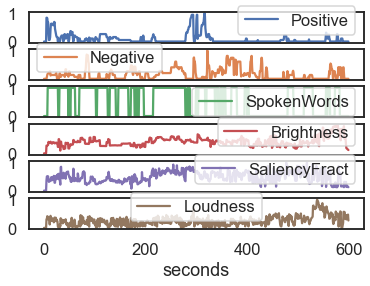

In [31]:
# load data
video_features_file = os.path.join(vid_dir, 'DM_summary_codes_intuitivenames.csv')
features = pd.read_csv(video_features_file, index_col=0).loc[:, vidfeat_of_interest]

# rescale to 0 to 1
from sklearn.preprocessing import MinMaxScaler
features.loc[:,:] = MinMaxScaler().fit_transform(features.to_numpy())

# save data
features.plot(subplots=True)

In [33]:
group_meanDMN = np.load(os.path.join(out_dir, 'group_mean_Default_ips_movieDM.npy'))
print(group_meanDMN.shape)

x=group_meanDMN 
y=features['Negative']
r,p = scp.pearsonr(x,y)
print(r,p)



(750,)
0.037323190161941695 0.3073546697372695


### compute IPS between each video feature and dynamic connectivity metric